In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime

In [3]:
sample_data = pd.read_excel('sample_movies.xlsx')

In [4]:
sample_data.shape

(21, 3)

In [5]:
sample_data.head(10)

,user,movie,rating
0,p1,Bahubali,5.0
1,p1,saaho,4.0
2,p2,Bahubali,4.0
3,p2,johnwick,3.0
4,p2,hangover,4.0
5,p2,spiderman,4.6
6,p3,saaho,4.0
7,p3,johnwick,3.0
8,p3,hangover,4.0
9,p3,kesari,2.0


In [6]:
#creating matrix (user-movie matrix)
mat = pd.pivot_table(sample_data,values='rating',index='user',columns='movie')
mat

movie,Bahubali,hangover,johnwick,kesari,saaho,spiderman
user,,,,,,
p1,5.0,NaN,NaN,NaN,4.0,NaN
p2,4.0,4.0,3.0,NaN,NaN,4.6
p3,NaN,4.0,3.0,2.0,4.0,NaN
p4,4.0,4.0,3.0,NaN,3.5,NaN
p5,5.0,NaN,4.0,4.0,4.0,NaN
p6,NaN,5.0,3.0,NaN,4.0,NaN


In [7]:
mat_cust = mat.apply(lambda x: x.fillna(x.mean()),axis=0)
mat_cust.head(10)

movie,Bahubali,hangover,johnwick,kesari,saaho,spiderman
user,,,,,,
p1,5.0,4.25,3.2,3.0,4.0,4.6
p2,4.0,4.00,3.0,3.0,3.9,4.6
p3,4.5,4.00,3.0,2.0,4.0,4.6
p4,4.0,4.00,3.0,3.0,3.5,4.6
p5,5.0,4.25,4.0,4.0,4.0,4.6
p6,4.5,5.00,3.0,3.0,4.0,4.6


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
user_user_mat = cosine_similarity(mat_cust)
np.fill_diagonal(user_user_mat, 0 )
sim_with_user = pd.DataFrame(user_user_mat,index=mat_cust.index)
sim_with_user.columns=mat_cust.index
sim_with_user.head()

user,p1,p2,p3,p4,p5,p6
user,,,,,,
p1,0.000000,0.996490,0.995180,0.996451,0.994060,0.995746
p2,0.996490,0.000000,0.992708,0.999209,0.992978,0.996072
p3,0.995180,0.992708,0.000000,0.991322,0.981578,0.992084
p4,0.996451,0.999209,0.991322,0.000000,0.993906,0.996109
p5,0.994060,0.992978,0.981578,0.993906,0.000000,0.988299


In [10]:
def neighbour_cust(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [11]:
top_4_cust = neighbour_cust(sim_with_user,4)
top_4_cust.head()

,top1,top2,top3,top4
user,,,,
p1,p2,p4,p6,p3
p2,p4,p1,p6,p5
p3,p1,p2,p6,p4
p4,p2,p1,p6,p5
p5,p1,p4,p2,p6


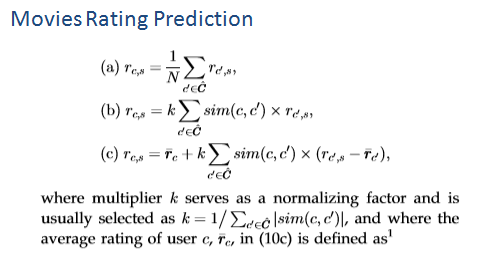

In [12]:
sample_data.loc[sample_data['user'] == 'p2','rating'].values

array([4. , 3. , 4. , 4.6])

In [13]:
a = top_4_cust[top_4_cust.index=='p2'].values
b = a.squeeze().tolist()
c = mat_cust.loc[:,'saaho']
d = c[c.index.isin(b)]
f = d[d.notnull()]

print(f)
avg_user = sample_data.loc[sample_data['user'] == 'p2','rating'].values[0]
index = f.index.values.squeeze().tolist()
corr = sim_with_user.loc['p2',index]

print('/')
print(corr)

user
p1    4.0
p4    3.5
p5    4.0
p6    4.0
Name: saaho, dtype: float64
/
user
p1    0.996490
p4    0.999209
p5    0.992978
p6    0.996072
Name: p2, dtype: float64


In [14]:
def User_item_score(user,item):
    a = top_4_cust[top_4_cust.index==user].values
    b = a.squeeze().tolist()
    c = mat_cust.loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    index = f.index.values.squeeze().tolist()
    corr = sim_with_user.loc[user,index]
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adg_score','correlation']
    fin['score']=fin.apply(lambda x:x['adg_score'] * x['correlation'],axis=1)
    nume = fin['score'].sum()
    deno = fin['correlation'].sum()
    final_score =  (nume/deno)
    return final_score

In [15]:
score = User_item_score('p2','kesari') 
print(score)

3.2491946606947657
